#### Import Library

In [1]:
import numpy as np
import scipy.linalg as la
import random, copy
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)
np.random.seed(42)

#### Configs

In [2]:
channel = 100
sampling = 200
trials = 300

#### Random sampling

In [3]:
class_1 = np.random.normal(0, 1, [sampling, channel, trials])
class_2 = np.random.normal(2, 1, [sampling, channel, trials])

print(f'LOG >>> sampling x channel x trials')
print(f'LOG >>> class_1 : {class_1.shape}')
print(f'LOG >>> class_2 : {class_2.shape}')

LOG >>> sampling x channel x trials
LOG >>> class_1 : (200, 100, 300)
LOG >>> class_2 : (200, 100, 300)


#### Get covariance matrix

In [4]:
C1_cov, C2_cov = [], []
for i in range(trials):
    C1_cov.append(np.cov(class_1[:,:,i].T))
    C2_cov.append(np.cov(class_2[:,:,i].T))
C1_cov = np.stack(C1_cov, axis=2)
C2_cov = np.stack(C2_cov, axis=2)

print(f'LOG >>> C1_cov: {C1_cov.shape}')
print(f'LOG >>> C2_cov: {C2_cov.shape}')

LOG >>> C1_cov: (100, 100, 300)
LOG >>> C2_cov: (100, 100, 300)


#### Get mean & sum of cov matrix

In [5]:
mean_C1_cov = np.mean(C1_cov, axis=2)
mean_C2_cov = np.mean(C2_cov, axis=2)

C_sum = mean_C1_cov + mean_C2_cov

print(f'LOG >>> C_sum: {C_sum.shape}')

LOG >>> C_sum: (100, 100)


#### Eigendecomposition

In [6]:
Eval, Evec = la.eig(C_sum)

print(f'LOG >> Eval: {Eval.shape}')
print(f'LOG >> Evec: {Evec.shape}')

LOG >> Eval: (100,)
LOG >> Evec: (100, 100)


/opt/anaconda3/envs/Dacon/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


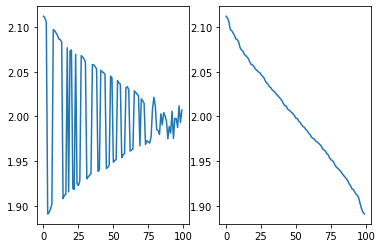

In [7]:
plt.subplot(121)
plt.plot(Eval)

plt.subplot(122)
plt.plot(sorted(copy.deepcopy(Eval), reverse=True))
plt.show()

In [8]:
ord = np.argsort(Eval)
ord = ord[::-1]
Eval = Eval[ord]
Evec = Evec[:,ord]

/opt/anaconda3/envs/Dacon/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


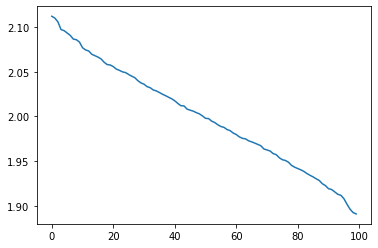

In [9]:
plt.plot(Eval)
plt.show()

#### Get P & S
$P = \sqrt {\lambda^-1} U'$

In [10]:
P = np.dot(np.sqrt(la.inv(np.diag(Eval))), Evec.T)

S1 = P.dot(mean_C1_cov).dot(P.T)
S2 = P.dot(mean_C2_cov).dot(P.T)

print(f'LOG >>> S1: {S1.shape}')
print(f'LOG >>> S2: {S2.shape}')

LOG >>> S1: (100, 100)
LOG >>> S2: (100, 100)


#### Get B

In [11]:
Eval_1, Evec_1 = la.eig(S1, S2)

print(f'LOG >>> Eval_1: {Eval_1.shape}')
print(f'LOG >>> Evec_1: {Evec_1.shape}')

LOG >>> Eval_1: (100,)
LOG >>> Evec_1: (100, 100)


In [12]:
ord_1 = np.argsort(Eval_1)
ord_1 = ord_1[::-1]
Eval_1 = Eval_1[ord_1]
B = Evec_1[:,ord_1]

print(f'LOG >>> Eval_1: {Eval_1.shape}')
print(f'LOG >>> B: {B.shape}')

LOG >>> Eval_1: (100,)
LOG >>> B: (100, 100)


#### Get CSP filter

In [15]:
CSP_filter = B.T.dot(P)

print(f'LOG >>> CSP_filter: {CSP_filter.shape}')

LOG >>> CSP_filter: (100, 100)


# Check

In [16]:
top = 2

In [33]:
selected_CSP_filter = np.concatenate((CSP_filter[:top, :], CSP_filter[-top:, :]))

print(f'LOG >>> selected_CSP_filter: {selected_CSP_filter.shape}')

LOG >>> selected_CSP_filter: (4, 100)


In [62]:
origin_C1, origin_C2 = [], []

for i in range(trials):
    
    var_signal_1 = np.var(class_1[:,:,i], axis=1)
    var_signal_2 = np.var(class_2[:,:,i], axis=1)
    
    origin_C1.append(np.log10(var_signal_1 / np.sum(var_signal_1)))
    origin_C2.append(np.log10(var_signal_2 / np.sum(var_signal_2)))

origin_C1 = np.stack(origin_C1, axis=0)
origin_C2 = np.stack(origin_C2, axis=0)

In [63]:
Feature_C1, Feature_C2 = [], []

for i in range(trials):
    trans_signal_C1 = selected_CSP_filter.dot(class_1[:,:,i].T)
    trans_signal_C2 = selected_CSP_filter.dot(class_2[:,:,i].T)
    
    var_signal_1 = np.var(trans_signal_C1, axis=1)
    var_signal_2 = np.var(trans_signal_C2, axis=1)
    
    Feature_C1.append(np.log10(var_signal_1 / np.sum(var_signal_1)))
    Feature_C2.append(np.log10(var_signal_2 / np.sum(var_signal_2)))

Feature_C1 = np.stack(Feature_C1, axis=0)
Feature_C2 = np.stack(Feature_C2, axis=0)

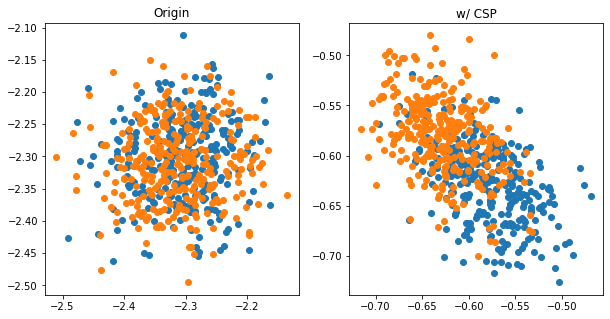

In [68]:
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.scatter(origin_C1[:, 0], origin_C1[:, -1])
plt.scatter(origin_C2[:, 0], origin_C2[:, -1])
plt.title('Origin')

plt.subplot(122)
plt.scatter(Feature_C1[:, 0], Feature_C1[:, -1])
plt.scatter(Feature_C2[:, 0], Feature_C2[:, -1])
plt.title('w/ CSP')
plt.show()